In [1]:
import math
import random
from PIL import Image


class Sample:
    def __init__(self, input, expected):
        self.input = input
        self.expected = expected


class Matrix:
    def __init__(self, values):
        self.values = values

    def add_matrix(self, other):
        res = get_empty_matrix(self.rows, self.columns)
        for i in range(self.rows):
            for j in range(self.columns):
                res.values[i][j] = self.values[i][j] + other.values[i][j]
        return res

    def multiply_matrix(self, other):
        res = get_empty_matrix(self.rows, other.columns)
        for i in range(self.rows):
            for j in range(other.columns):
                for k in range(self.columns):
                    res.values[i][j] += self.values[i][k] * other.values[k][j]
        return res

    def multiply_vector(self, other):
        res = get_empty_vector(self.rows)
        for i in range(self.rows):
            for j in range(self.columns):
                res.values[i] += self.values[i][j] * other.values[j]
        return res

    def multiply_scalar(self, value):
        res = get_empty_matrix(self.rows, self.columns)
        for i in range(self.rows):
            for j in range(self.columns):
                res.values[i][j] = value * self.values[i][j]
        return res

    def transpose(self):
        res = get_empty_matrix(self.columns, self.rows)
        for i in range(self.rows):
            for j in range(self.columns):
                res.values[j][i] = self.values[i][j]
        return res

    @property
    def rows(self):
        return len(self.values)

    @property
    def columns(self):
        if self.rows == 0:
            return 0
        return len(self.values[0])


class Vector:
    def __init__(self, values):
        self.values = values

    def get_max_index(self):
        ans = 0
        for i in range(self.elements):
            if self.values[i] > self.values[ans]:
                ans = i
        return ans

    @property
    def length(self):
        res = 0
        for i in self.values:
            res += i**2
        return math.sqrt(res)

    def add_vector(self, other):
        res = get_empty_vector(self.elements)
        for i in range(self.elements):
            res.values[i] = self.values[i] + other.values[i]
        return res

    def hadamar_product(self, other):
        res = get_empty_vector(self.elements)
        for i in range(self.elements):
            res.values[i] = self.values[i] * other.values[i]
        return res

    def to_matrix(self):
        return Matrix([[x] for x in self.values])

    def multiply_scalar(self, value):
        return self.map(lambda x: x * value)

    def map(self, func):
        return Vector(list(map(func, self.values)))

    @property
    def elements(self):
        return len(self.values)


def get_random_vector(n, a, b):
    res = get_empty_vector(n)
    for i in range(n):
        res.values[i] = random.uniform(a, b)
    return res

def get_random_matrix(n, m, a, b):
    res = get_empty_matrix(n, m)
    for i in range(n):
        for j in range(m):
            res.values[i][j] = random.uniform(a, b)
    return res


def get_empty_matrix(n, m):
    return Matrix([[0] * m for _ in range(n)])


def get_empty_vector(n):
    return Vector([0] * n)


def sigmoid(x):
    return 1 / (1 + math.exp(-x))


def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


def get_samples():
    samples = []
    for i in range(10):
        res = get_empty_vector(10)
        res.values[i] = 1
        for j in range(10):
            name = f"../datasets/digits/{i}_{j}.bmp"
            image = Image.open(name)
            vec = Vector([])
            for k in range(image.width):
                for l in range(image.height):
                    vec.values.append(image.getpixel((k, l)))
            samples.append(Sample(vec.multiply_scalar(1 / vec.length), res))
    return samples


In [2]:
import math

from matplotlib import pyplot as plt


ETA = 10


EPOCHS = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

class Prediction:
    def __init__(self, sample, prediction):
        self.sample = sample
        self.prediction = prediction


class ScoreResult:
    def __init__(self, accuracy, loss, predictions):
        self.accuracy = accuracy
        self.loss = loss
        self.predictions = predictions

    def __str__(self):
        return f"accuracy: {self.accuracy * 100}%, loss: {self.loss}"


class RunResult:
    def __init__(self, activations, weighted_inputs):
        self.activations = activations
        self.weighted_inputs = weighted_inputs


class Network:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [get_empty_matrix(0, 0)]
        self.biases = [get_empty_vector(0)]
        for i in range(1, len(layers)):
            self.weights.append(get_random_matrix(layers[i], layers[i - 1], -1, 1))
            self.biases.append(get_random_vector(layers[i], -1, 1))

    def train(self, samples, epochs):
        for epoch in range(epochs):
            print(f"{epoch + 1}/{epochs}")
            errors = []
            activations = []
            for sample in samples:
                result = self.run(sample)
                activations.append(result.activations)
                cur_errors = self.backprop(sample, result)
                errors.append(cur_errors)
            self.descend(samples, activations, errors)

    def run(self, sample):
        activations = [get_empty_vector(layer) for layer in self.layers]
        activations[0] = sample.input
        weighted_inputs = [get_empty_vector(layer) for layer in self.layers]
        for j in range(1, len(self.layers)):
            weighted_inputs[j] = (
                self.weights[j]
                .multiply_vector(activations[j - 1])
                .add_vector(self.biases[j])
            )
            activations[j] = weighted_inputs[j].map(self.calc_activation)
        return RunResult(activations, weighted_inputs)

    def backprop(self, sample, result):
        errors = [get_empty_vector(layer) for layer in self.layers]
        nabla_cost = self.calc_nabla_cost(sample.expected, result.activations[-1])
        errors[-1] = nabla_cost.hadamar_product(
            result.weighted_inputs[-1].map(self.calc_activation_derivative)
        )
        for j in reversed(range(1, len(self.layers) - 1)):
            errors[j] = (
                self.weights[j + 1]
                .transpose()
                .multiply_vector(errors[j + 1])
                .hadamar_product(result.weighted_inputs[j].map(self.calc_activation_derivative))
            )
        return errors

    def descend(self, samples, activations, errors):
        for i in range(1, len(self.layers)):
            acc_weights = get_empty_matrix(self.layers[i], self.layers[i - 1])
            acc_biases = get_empty_vector(self.layers[i])
            for j in range(len(samples)):
                acc_weights = acc_weights.add_matrix(
                    errors[j][i]
                    .to_matrix()
                    .multiply_matrix(activations[j][i - 1].to_matrix().transpose())
                )
                acc_biases = acc_biases.add_vector(errors[j][i])
            factor = -ETA / len(samples)
            self.weights[i] = self.weights[i].add_matrix(
                acc_weights.multiply_scalar(factor)
            )
            self.biases[i] = self.biases[i].add_vector(
                acc_biases.multiply_scalar(factor)
            )

    def score(self, samples):
        cost = 0
        accurate = 0
        predictions = []
        for sample in samples:
            res = self.run(sample)
            out = res.activations[-1]
            pred = Prediction(sample, out)
            predictions.append(pred)
            cost += self.calc_cost(sample.expected, out)
            if out.get_max_index() == sample.expected.get_max_index():
                accurate += 1
        return ScoreResult(accurate / len(samples), cost / len(samples), predictions)

    def calc_cost(self, expected, out):
        res = 0
        for y, a in zip(expected.values, out.values):
            res += - (y * math.log(a) + (1 - y) * math.log(1 - a))
        return res

    def calc_nabla_cost(self, expected, activations):
        res = get_empty_vector(activations.elements)
        for i in range(activations.elements):
            res.values[i] = (1 - expected.values[i]) / (1 - activations.values[i]) - expected.values[i] / activations.values[i]
        return res

    def calc_activation(self, x):
        return sigmoid(x)

    def calc_activation_derivative(self, x):
        return sigmoid_derivative(x)



1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20
1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30
30/30
1/40
2/40
3/40
4/40
5/40
6/40
7/40
8/40
9/40
10/40
11/40
12/40
13/40
14/40
15/40
16/40
17/40
18/40
19/40
20/40
21/40
22/40
23/40
24/40
25/40
26/40
27/40
28/40
29/40
30/40
31/40
32/40
33/40
34/40
35/40
36/40
37/40
38/40
39/40
40/40
1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50
1/60
2/60
3/60
4/60
5/60
6/60
7/60
8/60
9/60
10/60
11/60
12/60
13/60
14/60
15/60
16/60
17/60
18/60
19/60
20/60
21/60
22/60
23/60
24/60
25/60
26/6

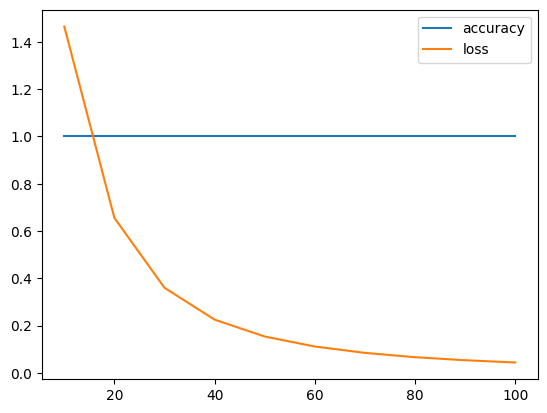

In [3]:

network = Network([24, 10])
samples = get_samples()
scores = []
for i, epochs in enumerate(EPOCHS):
    network.train(samples, epochs)
    scores.append(network.score(samples))

xs = EPOCHS
accuracies = []
losses = []
for i in range(len(EPOCHS)):
    y = scores[i]
    accuracies.append(y.accuracy)
    losses.append(y.loss)
    print('EPOCHS:', EPOCHS[i], y)

plt.plot(xs, accuracies)
plt.plot(xs, losses)
plt.legend(['accuracy', 'loss'])

